In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import h5py
import os
from os.path import join
import sys
import energyVS06 as energy

# for gif
import imageio
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation

import proplot as pplt
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

In [86]:
datadir = './Diagnostics/Data/Measurements/2022-04-26/'
os.listdir(datadir)

['.DS_Store', '220426155714-x2d-slit.h5', '220426160727-y1d-vs06.h5']

In [87]:
# HZ34a scan
filename = '220426160727-y1d-vs06.h5' 
L = 8.0036 - 6.13006
print('L = %.3f m'%L)

## HZ34b scan
# filename =''
# L = 8.0036 - 6.90450
# print('L = %.3f m'%L)

# slit-slit scan, L = 0.775
camname = 'cam34'
pix2mm = 0.05 # cam34 at zoom x1

L = 1.874 m


In [88]:
file = h5py.File(join(datadir, filename), 'r')
data = file['/scandata']
attrs = data.dtype.names
print(attrs)

act = []
for key in attrs:
    if 'PositionSync' in key:
        act.append(key)
print(act)

('timestamp', 'iteration', 'bcm04', 'cam34_Integral', 'cam34_ProfileY', 'cam34_Image', 'y_PositionSync')
['y_PositionSync']


In [89]:
ds = data  # change later

In [90]:
signal = ds[:,'%s_ProfileY'%camname].sum(axis=1)
np.shape(signal)

(42,)

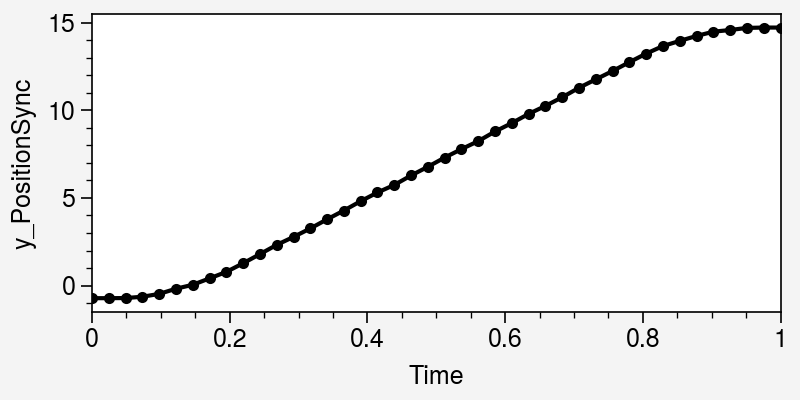

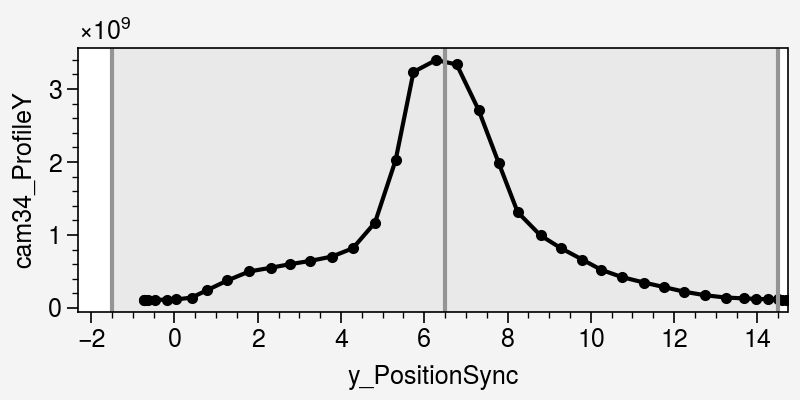

In [91]:
y0 = 6.5
dy = 16.0

tdata = np.linspace(0.0, 1.0, len(ds))

fig, ax = pplt.subplots(figsize=(4, 2))
#tpred = np.linspace(0,1,len(act1))
ax.plot(tdata, ds[:, act[0]], marker='.', color='black') #plt.plot(tpred,act3,':',color='C2')
ax.format(xlabel='Time', ylabel=act[0])
plt.show()

fig, ax = pplt.subplots(nrows=1, figsize=(4, 2))
ax.plot(ds[:, act[0]], signal, marker='.', color='black')
ax.axvline(y0 - 0.5 * dy, color='grey')
ax.axvline(y0 + 0.5 * dy, color='grey')
ax.axvline(y0, color='grey')
ax.axvspan(y0 - 0.5 * dy, y0 + 0.5 * dy, color='grey', alpha=0.2)
# ax.axvline(y0 - 0.5 * dy)
# plt.plot([y0-dy/2.,y0-dy/2.],yl,'k')
# plt.plot([y0+dy/2.,y0+dy/2.],yl,'k')
ax.format(xlabel=act[0], ylabel=f'{camname}_ProfileY')
plt.show()

In [92]:
# plt.set_cmap('viridis')
# plt.figure(figsize=[16,4])

# tdata = np.linspace(0,1,len(ds))
# #tpred = np.linspace(0,1,len(act1))
# plt.plot(tdata,ds[:,act[0]],'.-'); #plt.plot(tpred,act3,':',color='C2')

# plt.figure(figsize=[10, 4])
# #plt.plot(ds[:,'y_PositionSync'],ds[:,'yp_PositionSync'],'.-')
# plt.plot(ds[:,act[0]],signal,'s')
# plt.grid(True)

# plt.figure(figsize=[10, 4])
# #plt.plot(ds[:,'y_PositionSync'],ds[:,'yp_PositionSync'],'.-')
# plt.plot(ds[:,act[0]],signal,'s')
# plt.semilogy()
# plt.grid(True)

# y0 = 5.0
# dy = 14.0
# yl = plt.ylim()
# plt.plot([y0,y0],yl,'k:')
# plt.plot([y0-dy/2.,y0-dy/2.],yl,'k')
# plt.plot([y0+dy/2.,y0+dy/2.],yl,'k')

# plt.ylim(yl)

peak at y_PositionSync=6.282 mm


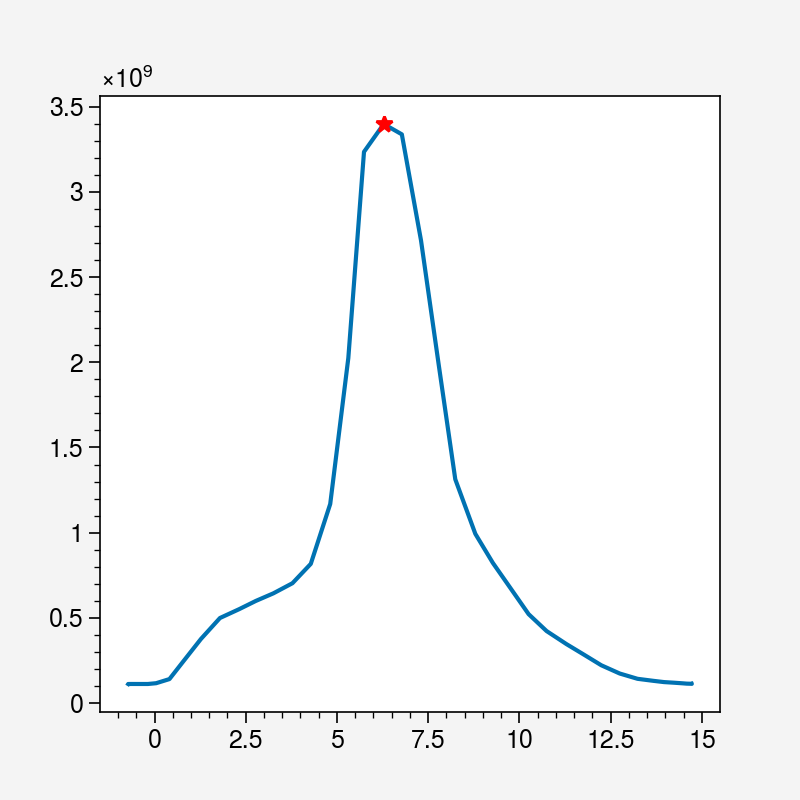

In [93]:
w = signal
plt.plot(ds[:,act[0]],w)
idx = np.argmax(w)
plt.plot(ds[idx,act[0]],w[idx],'*r')
print('peak at %s=%.3f mm'%(act[0],ds[idx,act[0]]))

## Plot images

In [94]:
ny = 512
nx = 612

# skip = 3
# nfigs = len(ds)/skip

# ncol = 6
# nrow = int(np.ceil(nfigs/ncol))
# plt.figure(figsize=[ncol*2,nrow*2])

# counter = 0
# for i in range(0,len(ds),skip):
#     counter += 1
#     plt.subplot(nrow,ncol,counter)
#     ima = np.reshape(ds[i,'%s_Image'%camname],[ny,nx])
#     plt.pcolor(np.log10(ima))
#     plt.xticks([]); plt.yticks([])
    
# plt.tight_layout()
# plt.show()

## Reconstruct phase space; projection

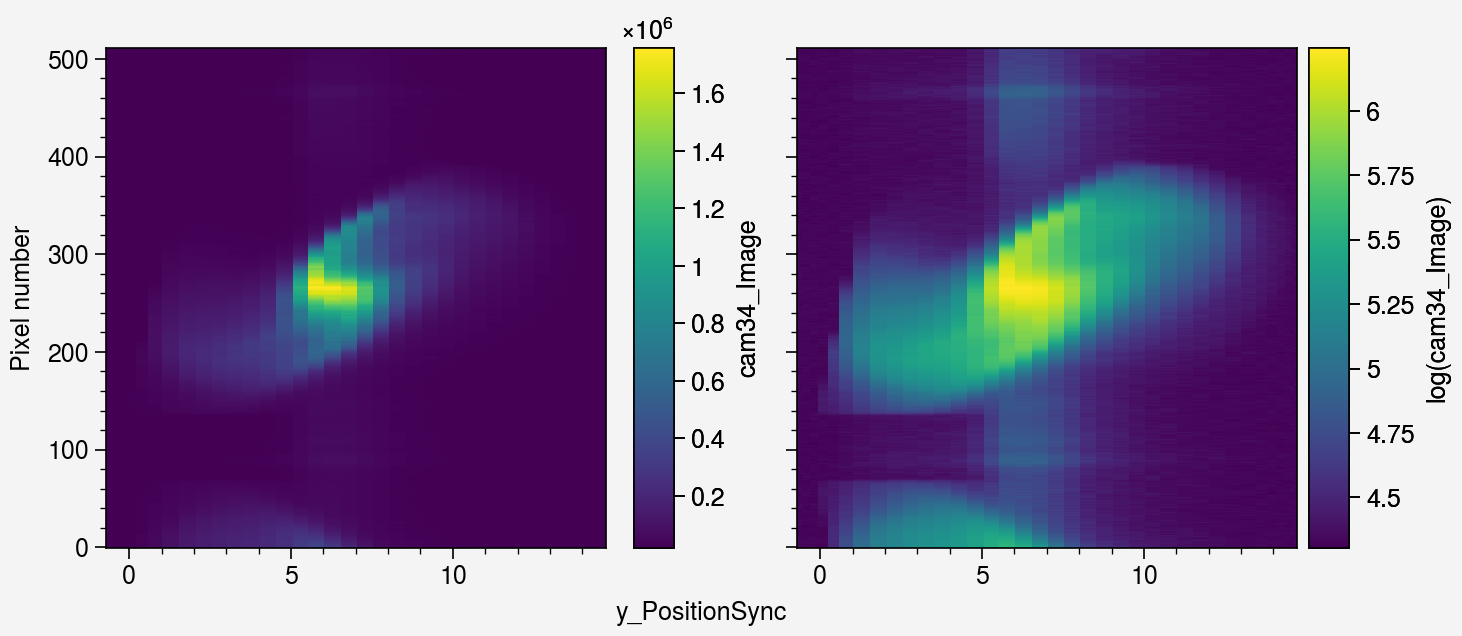

In [108]:
lds = len(ds)
yyp = np.zeros([ny, len(ds)])
for i in range(0,len(ds)):
    ima = np.reshape(ds[i, '%s_Image'%camname], [ny, nx])
    yp_prof = ima.sum(axis=1)
    yyp[:, i] = yp_prof
    
fig, axes = pplt.subplots(ncols=2, sharey=True)
axes[0].pcolormesh(data[:, 'y_PositionSync'], np.arange(ny), yyp, 
                   colorbar=True, colorbar_kw=dict(label=f'{camname}_Image'))
axes[1].pcolormesh(data[:, 'y_PositionSync'], np.arange(ny), np.log10(yyp), 
                   colorbar=True, colorbar_kw=dict(label=f'log({camname}_Image)'))
axes.format(xlabel='y_PositionSync', ylabel='Pixel number')
plt.show()

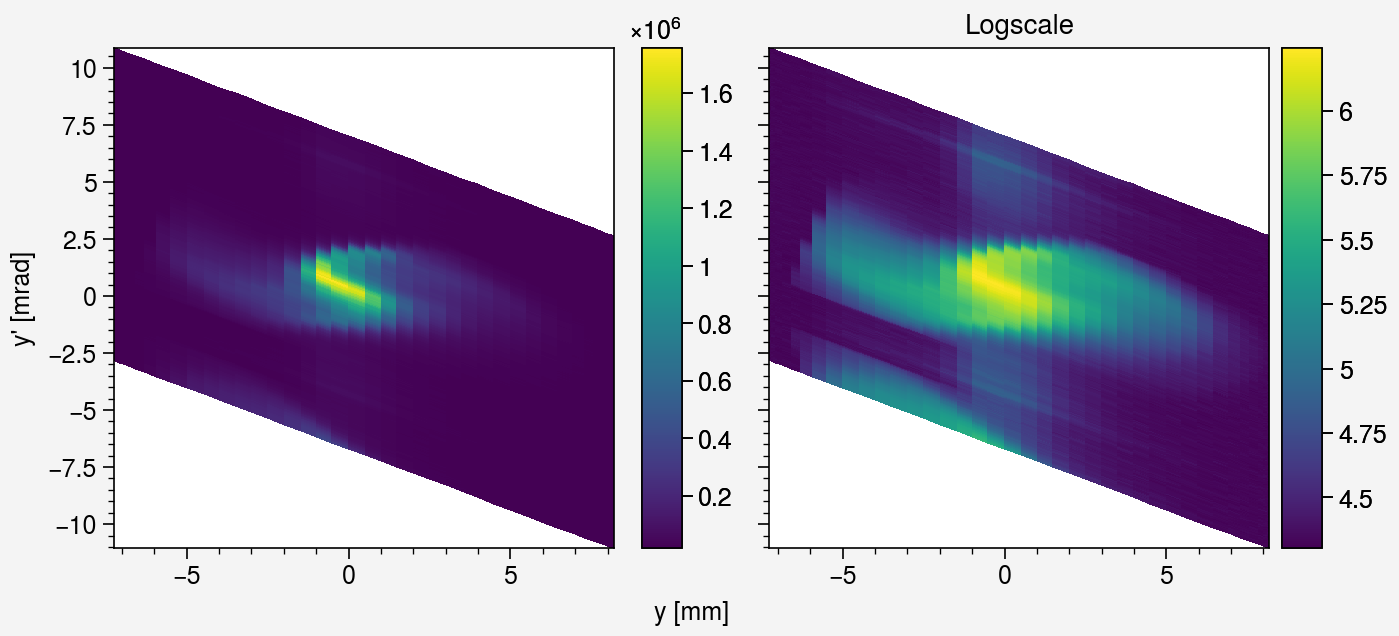

In [110]:
yscreen = np.arange(ny) * pix2mm  # 0.09 is an estimate based on old camera calibration. this needs to be redone
Y1, Y2 = np.meshgrid(ds[:, 'y_PositionSync'], yscreen)
Y = Y1 - np.average(ds[:, 'y_PositionSync'], weights=np.sum(yyp, axis=0))
YP = (Y2 - np.average(yscreen, weights=np.sum(yyp, axis=1)) - Y) / L


fig, axes = pplt.subplots(ncols=2, sharey=True)
axes[0].pcolormesh(Y, YP, yyp, colorbar=True)
axes[1].pcolormesh(Y, YP, np.log10(yyp), colorbar=True)
axes.format(xlabel="y [mm]", ylabel="y' [mrad]")
axes[1].set_title('Logscale')
plt.show()

## Reconstruct phase space; energy slice

phase space is already a slice in x,x' (near beam center, but not precisely)

yyp3d axes are y3,x3,y1

In [ ]:
yyp3d = np.zeros([ny,nx,lds])

for i in range(0,len(ds)):
    ima = np.reshape(ds[i,'%s_Image'%camname],[ny,nx])
    yyp3d[:,:,i] = ima
    


# GIF

#### cam34 image vs y-slit

In [ ]:
labeller = lambda x: '%.1f'%np.log10(x)
contour_levels = tuple([10**i for i in [-4,-3,-2,-1]])
default_norm = colors.LogNorm(vmin=1e-4, vmax=1, clip=False)

def thisplot(array2plot,labels,norm=default_norm,ax1=None,ax2=None):
    try:
        plt.pcolor(ax1,ax2,array2plot)
    except:
        plt.pcolor(array2plot)
    plt.xlabel(labels[0]); plt.ylabel(labels[1])
    plt.colorbar()
    # -- contour
    try:
        CS = plt.contour(ax1,ax2,array2plot/array2plot.max(),levels=contour_levels,norm=norm,cmap='Set1')
    except:
        CS = plt.contour(array2plot/array2plot.max(),levels=contour_levels,norm=norm,cmap='Set1')
    plt.clabel(CS,fmt = labeller)
    
    

def plot_image(image,log=False, nx_=nx, ny_=ny,norm=default_norm,labels=['',''],trace=True):
    xpx = np.arange(np.shape(image)[1])
    ypx = np.arange(np.shape(image)[0])
    sumima = image.sum().sum()
    profx = image.sum(axis=0) / sumima
    profy = image.sum(axis=1) / sumima
    
    if log:
        plt.pcolor(xpx,ypx,np.log10(image))
        if trace:
            plt.plot(xpx,0.1*ny_*(3+np.log10(profx/profx.max())),'r')
            plt.plot(0.1*nx_*(3+np.log10(profy/profy.max())),ypx,'r')
        plt.ylim([0,ny_])
        plt.xlim([0,nx_])
        plt.xlabel(labels[0]); plt.ylabel(labels[1])
    else:  
        #thisplot(image,labels,ax1=xpx,ax2=ypx,norm=norm)
        plt.pcolor(xpx,ypx,image,shading='auto')
        if trace:
            plt.plot(xpx,ny_*0.2*profx/profx.max(),'w')
            plt.plot(1+nx_*0.2*profy/profy.max(),ypx,'w')
        

In [ ]:
norm_pixel_value = np.max(ds[:,'%s_Image'%camname])

lds = len(ds)
images = []
for i in range(lds):
    
    #ima = make_image(i,plotFlag=False,log=False,trace=False)
    ima = yyp3d[:,:,i]
                              
    # -- normalize all frames in sweep to same pixel
    #ima = np.log10(ima) / np.log10(norm_pixel_value)
    #ima = np.log10(ima) / np.log10(np.max(ima))
    ima = ima/np.max(ima)
    #ima = ima/norm_pixel_value
    #ima = ima / np.max(ima)
    # BW
    #images.append(np.uint8(ima*np.iinfo(np.uint8).max))
    # color
    ima_rgb = cm.viridis(ima)
    images.append(np.uint8(ima_rgb*np.iinfo(np.uint8).max))
    
imageio.mimsave(filename+'-%s-screen-unorm.gif'%camname, images, fps=3)


plt.imshow(images[30]); 
plt.colorbar()


#### slit/screen coordinates

In [ ]:
x3 = np.arange(nx)*pix2mm
y3 = np.arange(ny)*pix2mm
y1 = ds[:,'y_PositionSync']

x3 = x3 - np.average(x3,weights=yyp3d.sum(axis=0).sum(axis=1))
# negative signs flip y-slit and y-screen axes
y3 = -1*(y3 - np.average(y3,weights=yyp3d.sum(axis=1).sum(axis=1)))
y1 = -1*(y1 - np.average(y1,weights=yyp3d.sum(axis=0).sum(axis=0)))

Y3,X3,Y1 = np.meshgrid(y3,x3,y1,indexing='ij')

In [ ]:
log = False
   
plt.figure(figsize=[18,5])
plt.subplot(131)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
plt.pcolor(x3,y1,yyp3d.sum(axis=0).T,norm=norm); plt.title('y projection vs dE'); plt.xlabel('x-screen [mm]'); plt.ylabel('y-slit [mm]')
plt.subplot(132)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=2).min(), vmax=yyp3d.sum(axis=2).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=2).min(), vmax=yyp3d.sum(axis=2).max())
plt.pcolor(x3,y3,yyp3d.sum(axis=2),norm=norm); plt.title('yp projection vs dE'); plt.xlabel('x-screen [mm]'); plt.ylabel('y-screen [mm]')
plt.subplot(133)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
plt.pcolor(y1,y3,yyp3d.sum(axis=1),norm=norm); plt.title('yp vs y'); plt.xlabel('y-slit [mm]'); plt.ylabel('y-screen [mm]')
                                                                                                

In [ ]:
# -- matrix params
a2mm = 1.009 # assume same as first dipole
rho = 0.3556
GL05 = 0
GL06 = 0.0
l1 = 0
l2 = 0
l3 = 0.774
L2 = 0.311 # slit2 to dipole face
l = 0.129 # dipole face to VS06 screen (assume same for 1st and last dipole/screen)
LL = l1+l2+l3+L2 # distance from emittance plane to dipole entrance

ecalc = energy.energyCalculate(l1=l1,l2=l2,l3=l3,L2=L2,l=l,amp2meter=a2mm*1e3)

#Mslit = ecalc.getM1() # slit-slit
Mscreen = ecalc.getM2() # 2nd-slit to screen

## -- matrix mupltiply to get yp, w
## 3D grids
Y = Y1.copy()
YP = ecalc.calculate_yp(Y.flatten()*1e-3,Y3.flatten()*1e-3,Mscreen)
YP = YP.reshape(np.shape(Y))*1e3
W = ecalc.calculate_dE_screen(X3.flatten()*1e-3, 0, 0, 0, Mscreen)
W = W.reshape(np.shape(Y))*1e3

w = ecalc.calculate_dE_screen(x3*1e-3, 0, 0, 0, Mscreen)*1e3



In [ ]:
log = True
   
plt.figure(figsize=[12,5])
plt.subplot(121)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
plt.pcolor(W.mean(axis=0).T,Y.mean(axis=0).T,yyp3d.sum(axis=0).T,norm=norm); plt.title('y projection vs dE'); plt.xlabel('w [keV]'); plt.ylabel('y [mm]')
plt.subplot(122)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
plt.pcolor(Y.mean(axis=1),YP.mean(axis=1),yyp3d.sum(axis=1),norm=norm); plt.title('yp vs y'); plt.xlabel('y [mm]'); plt.ylabel('yp [mrad]')
                                                                                                

In [ ]:
plt.plot(w,yyp3d.sum(axis=0).sum(axis=1))
#plt.semilogy()
plt.grid()

#### y-yp vs w

In [ ]:
idx = np.arange(150,520,1)
lidx = len(idx)
images = []

for i in range(lidx):
    
    ima = yyp3d[:,idx[i],:]
    # repeat columns to strech image
    ima = np.repeat(ima,7,1)
                              
    # -- normalize all frames in sweep to same pixel
    #ima = np.log10(ima) / np.log10(norm_pixel_value)
    #ima = np.log10(ima) / np.log10(np.max(ima))
    ima = ima/np.max(ima)
    #
    #ima = ima / np.max(ima)
    # BW
    #images.append(np.uint8(ima*np.iinfo(np.uint8).max))
    # color
    ima_rgb = cm.viridis(ima)
    img = np.uint8(ima_rgb*np.iinfo(np.uint8).max)   
    images.append(img)
    
imageio.mimsave(filename+'-vs-energy.gif', images, fps=30)


plt.imshow(images[30]); 
plt.colorbar()


## Make animation of y-yp phase space vs energy

In [ ]:
log=False
contour=True

fig, (ax1,ax2)= plt.subplots(1,2)
fig.set_tight_layout(True)
fig.set_dpi(300)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# initial plot
idxmax=np.argmax(yyp3d)
idxmax = np.unravel_index(idxmax,np.shape(yyp3d))
i=idxmax[1]



# left plot shows energy distribution at beam center (or integrated..choose which)
wprof = yyp3d[idxmax[0],:,idxmax[2]]#.sum(axis=0).sum(axis=1)
w_curve, = ax1.plot(w,wprof,'-'); 
w_point, = ax1.plot(w[i],wprof[i],'o',color='C0');
if log:
    ax1.semilogy()
ax1.set_ylabel('signal [a.u.]')
ax1.set_xlabel('w [keV]')

#right plot shows y-y' phase space

if log:
    norm=colors.LogNorm(vmin=yyp3d.min(), vmax=yyp3d.max())
else:
    norm=colors.Normalize(vmin=yyp3d.min(), vmax=yyp3d.max())
implot = ax2.pcolormesh(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],norm=norm)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
ax2.set_ylabel('y\' [mrad]')
ax2.set_xlabel('y [mm]')

# contours on right plot
labeller = lambda x: '%.1f'%np.log10(x)
contour_levels = tuple([10**i for i in [-4,-3,-2,-1]])
default_norm = colors.LogNorm(vmin=1e-4, vmax=1, clip=False)
if contour:
    ax2.contour(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:]/yyp3d[idxmax],levels=contour_levels,norm=default_norm,cmap='Set1')
#plt.clabel(CS,fmt = labeller)


def update(i):

    # left plot - move point
    w_point.set_ydata(wprof[i])
    w_point.set_xdata(w[i])

    # right plot -- update image
    #ax2.set_xdata(Y[:,i,:])
    # implot.set_paths(Y[:,i,:],YP[:,i,:])
    # implot.set_array(yyp3d[:,i,:])
    ax2.cla()
    ax2.pcolormesh(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],norm=norm)
    if contour:
        ax2.contour(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:]/yyp3d[idxmax],levels=contour_levels,norm=default_norm,cmap='Set1')
    ax2.set_xlim([-10,10])
    ax2.set_ylim([-10,10])
    ax2.set_ylabel('y\' [mrad]')
    ax2.set_xlabel('y [mm]')
        
    #axis.set_title(label)
    return w_point,ax2

# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
idx = np.arange(150,520,1)
anim = FuncAnimation(fig, update, frames=idx, interval=20)
anim.save('%s_yyp_vs_energy_linear.gif'%filename, dpi=300)#, writer='imagemagick')

## Calculate emittance

First, for projected emittance (still slice in x,x')

In [ ]:
log=False
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())

thr = 6.*np.median(yyp3d.sum(axis=1).flatten())
print('Thr at 10^%.2f fraction of peak'%np.log10(thr/yyp3d.sum(axis=1).max()))

i = idxmax[1]
plt.pcolormesh(Y.mean(axis=1),YP.mean(axis=1),yyp3d.sum(axis=1),norm=norm)
#plt.contour(Y.mean(axis=1),YP.mean(axis=1),yyp3d.sum(axis=1),levels=[thr],colors=['r'])
plt.ylim([-10,10])
plt.xlim([-10,10])

# emittance
weights = yyp3d.sum(axis=1)
weights[weights<thr] = 0
plt.contour(Y.mean(axis=1),YP.mean(axis=1),weights,levels=[thr],colors=['r'])
xc = np.average(Y.mean(axis=1),weights=weights)
sigxsq = np.average((Y.mean(axis=1)-xc)**2,weights=weights)
xpc = np.average(YP.mean(axis=1),weights=weights)
sigxpsq = np.average((YP.mean(axis=1)-xpc)**2,weights=weights)
sigxxp = np.average((Y.mean(axis=1)-xc)*(YP.mean(axis=1)-xpc),weights=weights)

emit0 = np.sqrt(sigxsq*sigxpsq - sigxxp**2)
bet0 = sigxsq/emit0
gam0 = sigxpsq/emit0
alph0 = np.sqrt(gam0*bet0-1)
sigx0 = np.sqrt(sigxsq)
sigxp0 = np.sqrt(sigxpsq)

print('Emittance: %.3f mm-mrad\nalpha = %.3f\nbeta = %.3f\ngamma = %.3f'%(emit0,alph0,bet0,gam0))
print('sigma x = %.3f mm\nsigma x\' = %.3f mrad'%(sigx0,sigxp0))

## Slice emittance

In [ ]:
log=False
if log:
    norm=colors.LogNorm(vmin=yyp3d.min(), vmax=yyp3d.max())
else:
    norm=colors.Normalize(vmin=yyp3d.min(), vmax=yyp3d.max())

thr = 7*np.median(yyp3d.flatten())
print('Thr at 10^%.2f fraction of peak'%np.log10(thr/yyp3d.max()))

i = idxmax[1]
plt.pcolormesh(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],norm=norm)
plt.contour(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],levels=[thr],colors=['r'])
plt.ylim([-10,10])
plt.xlim([-10,10])


In [ ]:
if log:
    norm=colors.LogNorm(vmin=yyp3d.min(), vmax=yyp3d.max())
else:
    norm=colors.Normalize(vmin=yyp3d.min(), vmax=yyp3d.max())

idx = np.arange(150,520,1)
emit,alph,bet,gam,sigx,sigxp = np.zeros([6,len(idx)])
for i in range(len(idx)):
    
    weights = yyp3d[:,idx[i],:].copy()
    weights[weights<thr] = 0
    if np.sum(weights) > 0:
        xc = np.average(Y[:,idx[i],:],weights=weights)
        sigxsq = np.average((Y[:,idx[i],:]-xc)**2,weights=weights)
        xpc = np.average(YP[:,idx[i],:],weights=weights)
        sigxpsq = np.average((YP[:,idx[i],:]-xpc)**2,weights=weights)
        sigxxp = np.average((Y[:,idx[i],:]-xc)*(YP[:,idx[i],:]-xpc),weights=weights)

        emit[i] = np.sqrt(sigxsq*sigxpsq - sigxxp**2)
        bet[i] = sigxsq/emit[i]
        gam[i] = sigxpsq/emit[i]
        alph[i] = np.sqrt(gam[i]*bet[i]-1)
        sigx[i] = np.sqrt(sigxsq )
        sigxp[i] = np.sqrt(sigxpsq )

In [ ]:
plt.figure()
plt.plot(w[idx],emit); plt.ylim([0,5]); plt.grid()
plt.plot(plt.xlim(),[emit0,emit0])
plt.xlabel('w [keV]')
plt.ylabel('rms y emittance [mm-mrad, unnorm.]')

plt.figure()
plt.plot(w[idx],sigx); plt.ylim([0,3]); plt.grid()
plt.plot(plt.xlim(),[sigx0,sigx0])
plt.xlabel('w [keV]')
plt.ylabel('rms y [mm]')

plt.figure()
plt.plot(w[idx],sigxp); plt.ylim([0,3]);  plt.grid()
plt.plot(plt.xlim(),[sigxp0,sigxp0])
plt.xlabel('w [keV]')
plt.ylabel('rms y\' [mrad]')

plt.figure()
plt.plot(w[idx],alph); plt.ylim([-.1,.5]);  plt.grid()
plt.plot(plt.xlim(),[alph0,alph0])
plt.xlabel('w [keV]')
plt.ylabel('rms alpha')

plt.figure()
plt.plot(w[idx],bet); plt.grid()
plt.plot(plt.xlim(),[bet0,bet0])
plt.xlabel('w [keV]')
plt.ylabel('rms beta [m]')

plt.figure()
plt.plot(w[idx],gam); plt.ylim([0,1.5]);   plt.grid()
plt.plot(plt.xlim(),[gam0,gam0])
plt.xlabel('w [keV]')
plt.ylabel('rms gamma')